
## Applied Data Analysis Project
**Team**: ToeStewBrr - Alexander Sternfeld, Marguerite Thery, Antoine Bonnet, Hugo Bordereaux

**Dataset**: CMU Movie Summary Corpus

# Part 3: Textual Analysis

In this notebook, we analyze the pre-processed output of our custom CoreNLP pipeline. 

### Table of contents
1. [Loading pre-processed coreNLP data](#section1)
2. [Persona clusters](#section2)
    - 2.1. [Embedding descriptions](#section2-1)
    - 2.2. [Principal Component Analysis (PCA)](#section2-2)
    - 2.3. [Clustering personas](#section2-3)
    - 2.4. [Visualizing persona clusters](#section2-4)

**Prerequisite**: 

Install [spaCy](https://spacy.io) using the following commands: 

        pip install spacy
        
        python3 -m spacy download en_core_web_sm

In [1]:
import os
import pickle
import spacy
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from ast import literal_eval


from extraction import *
from coreNLP_analysis import *
from load_data import *
from textual_analysis import *


# NOTE: If you haven't loaded NLTK before, set this to True
load_nltk = False

if load_nltk: #Load the spaCy model for the semantic analysis
    nlp_spacy = spacy.load("en_core_web_lg")

pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abonnet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/abonnet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Load pre-processed coreNLP data <a class="anchor" id="section1"></a>

We first load the pre-processed output from our custom CoreNLP pipeline. 

In [2]:
char_description_path = 'Data/CoreNLP/char_descriptions.csv'
full_description_path = 'Data/CoreNLP/full_descriptions.csv'

# Load character descriptions
char_description_df = pd.read_csv(char_description_path, sep='\t', index_col=None, low_memory=False)

# Convert to lists
char_description_df['agent_verbs'] = char_description_df.agent_verbs.apply(
    lambda x: literal_eval(x) if type(x) == str else x)
char_description_df['patient_verbs'] = char_description_df.patient_verbs.apply(
    lambda x: literal_eval(x) if type(x) == str else x)
char_description_df['attributes'] = char_description_df.attributes.apply(
    lambda x: literal_eval(x) if type(x) == str else x)
char_description_df['descriptions'] = char_description_df.descriptions.apply(
    lambda x: literal_eval(x) if type(x) == str else x)
char_description_df['title'] = char_description_df.title.apply(
    lambda x: literal_eval(x) if type(x) == str else x)

full_description_df = pd.read_csv(full_description_path, sep='\t', index_col=None, low_memory=False)

## 2. Persona clusters <a class="anchor" id="section2"></a>

### 2.1. Embedding descriptions <a class="anchor" id="section2-1"></a>

We embed all descriptive words (actions, attributes, titles) of all characters into a high-dimensional vector space using spaCy. 

In [3]:
embedding_file = 'Data/CoreNLP/char_description_embeddings.pickle'
# If you haven't been here for a while, please delete the old pkl file you may still have
# If we have already embedded the descriptions, load them from the pickle file, else execute code below
if os.path.exists(embedding_file):
    char_description_df = pd.read_pickle(embedding_file)

else:
    # Embed descriptions (Get a comfy chair, this takes a while) 
    char_description_df = construct_descriptions_embeddings(char_description_df, nlp_spacy)
    # Split embeddings by category
    char_description_df = embeddings_categorical(char_description_df)
    # Save the embeddings to a pickle file
    with open(embedding_file, 'wb') as f:
        pickle.dump(char_description_df, f)

### 2.2. Weighted average of word vectors <a class="anchor" id="section2-2"></a>

We then weigh the word embedding of each word for each character by their cosine distance to the average semantic vector of words with the sam type used for all characters in the dataset. The *cosine distance* is defined as:

$$\text{cosine distance}(x_1, x_2) = 1-\frac{x_1 \cdot x_2}{||x_1||\cdot||x_2||}$$

where $x_1$ and $x_2$ are the vector representations of two words.

In [90]:
weight_df = weight_embeddings(char_description_df, column='title', percentile=0)

weight_df = weight_embeddings(weight_df, column='attributes', percentile=50)

weight_df = weight_embeddings(weight_df, column='agent_verbs', percentile=70)

weight_df = weight_embeddings(weight_df, column='patient_verbs', percentile=85)

weight_df = weight_embeddings(weight_df, column='descriptions', title_weight=0.35)

### 2.3. Dimensionality reduction <a class="anchor" id="section2-3"></a>

#### 2.3.1. Principal Component Analysis (PCA) <a class="anchor" id="section2-3-1"></a>

To visualize our clusters, we then map these high-dimensional descriptive vectors to 50-dimensional space using PCA to prepare the ground for a second dimensionality reduction technique. 

In [91]:
# Remove rows in char_description_df that have less than X descriptions
min_words = 5
df = weight_df.copy(deep=True)
df = df[df.descriptions.apply(lambda x: type(x) != float)]
df = df[df.descriptions.apply(lambda x: len(x) >= min_words)]
print('Percentage of characters with at least {} descriptions: {:.2f}%'.format(min_words, 100*len(df)/len(weight_df)))

Percentage of characters with at least 5 descriptions: 56.01%


In [92]:
# Dimensionality reduction: PCA to 50 dimensions -> t-SNE to 3 dimensions
desc = 'descriptions'
column = 'weighted_descriptions_embeddings'
n_total = df[column].apply(lambda x: 1 if type(x) == np.ndarray else 0).sum()
pca_df = descriptions_PCA(df, column=column, n_components=50)

#### 2.3.2. *t*-distributed Stochastic Neighbor Embedding (t-SNE) <a class="anchor" id="section2-3-2"></a>

We now perform [t-SNE dimensionality reduction](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) on the pre-reduced weighted embeddings. 

In [93]:
tsne_df = descriptions_tSNE(pca_df, column=column, n_components=3, learning_rate='auto')

/Users/abonnet/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [96]:
# Save the embeddings to a pickle file
pickle_file = 'Data/CoreNLP/char_description_embeddings_tsne.pickle'
with open(pickle_file, 'wb') as f:
    pickle.dump(tsne_df, f)

### 2.4. Clustering personas <a class="anchor" id="section2-4"></a>

The persona point cloud is clustered into several categories using DBSCAN. 

In [192]:
eps = 5.8
min_samples = 88

cluster_df, n_clusters, n_removed = DBSCAN_cluster(tsne_df, column, method='tsne', eps=eps, min_samples=min_samples)


### 2.5. Visualizing persona clusters <a class="anchor" id="section2-5"></a>

The clustered persona point cloud is shown below. 

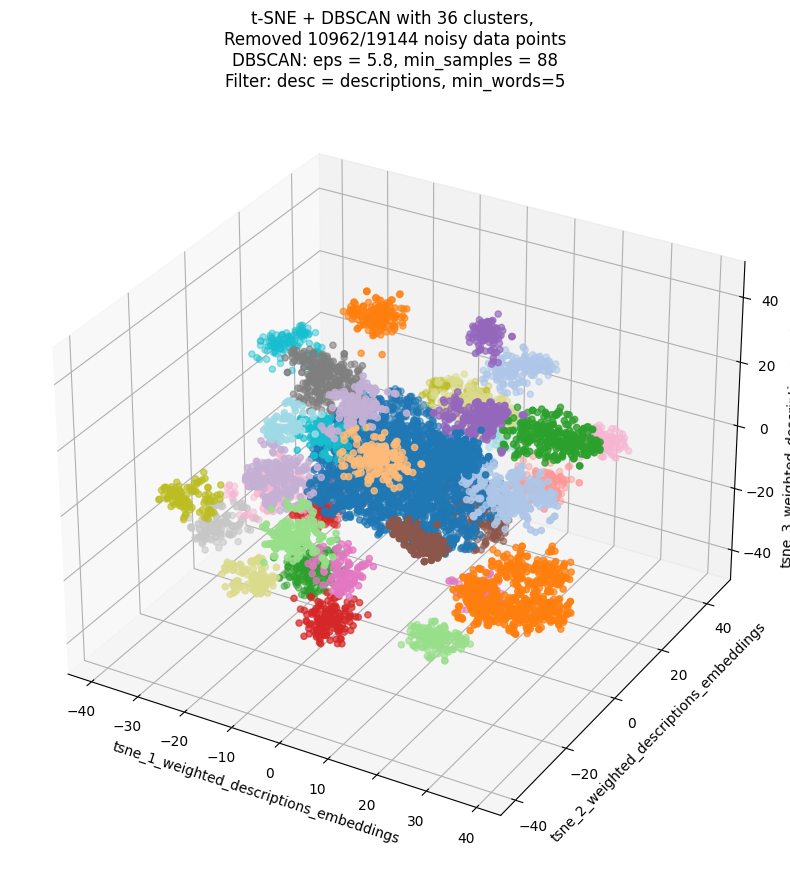

In [193]:
title = 't-SNE + DBSCAN with {} clusters, \nRemoved {}/{} noisy data points\nDBSCAN: eps = {}, min_samples = {}\nFilter: desc = {}, min_words={}'.format(
    n_clusters, n_removed, n_total, eps, min_samples, desc, min_words)
plot_clusters_3d(cluster_df, title, column=column)